# Configuración básica de una red neuronal convolucional.

Una vez hemos estudiado los conceptos básicos de las redes convolucionales como las capas convolucionales y de Pooling, es hora de construir nuestra propia red. Como ejemplo usaremos la base de datos fashion Mnist.

## Etapa 1: Se carga la base de datos.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
print(x_train.shape) # El conjunto de entrenamiento está compuesto por 60000
                     # imágenes de tamaño 28x28

(60000, 28, 28)


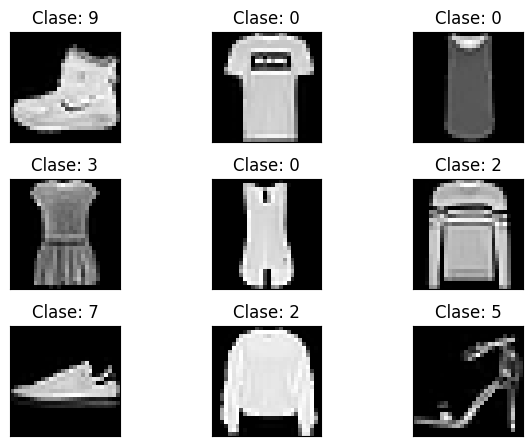

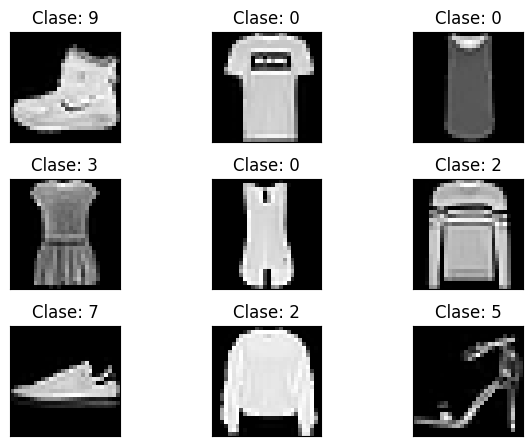

In [4]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Clase: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
fig

## Etapa 2:  Se procesan las imágenes para que sean compatibles con la red convolucional.

Ahora, se normalizan los datos para que las imágenes tomen valores en el intervalo (0,1)

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0

Se hace un reshape de la imagen para agregar una nueva dimensión, la cual representa el número de canales de la imagen. Como estamos usando imágenes en escala de grises, la imagen solo contará con un canal. Por otro lado, las imágenes a color se representan, usualmente, a partir de tres canales RGB, rojo, verde y azul. Para profundizar más acerca de las representaciones de las imágenes a color y en escala de grises, los invito a leer la siguiente publicación [Enlace.](https://towardsdatascience.com/exploring-the-mnist-digits-dataset-7ff62631766a)

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

## Etapa 3: Definición del modelo 

Ahora, es momento de definir el modelo de redes convolucionales. Usualmente, las capas de pooling se alimentan de las salidas de las capas convolucionales. Así, se suele definir como una capa oculta al conjunto de una capa convolucional más una capa de Pooling.


Para este ejemplo definimos una red simple compuesta por dos capas ocultas y una capa de salida de tipo Densa con 10 unidades.


In [7]:
model = keras.Sequential([
    # La primera capa oculta se compone de una capa convolucional con filters = 32
    # filtros, cada uno con tamaño kernel_size=3x3. Definimos padding="valid", con 
    # el fin de no realizar ningún relleno; Además, definimos un stride=1 con una 
    # no-lineal de tipo RELU. Finalmente, definimos el tamaño de las imágenes de 
    # entrada como (28,28,1), notemos que no se definimos la cantidad de imágenes
    # debido a que este dependerá del tamaño del lote que usemos.
    # Con los hiperparámetros elegidos, la salida de la convolución será de tamaño
    # 26x26x32
    keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding="valid", 
                        strides=(1, 1), activation='relu',input_shape=(28, 28, 1)),
    # Luego, el resultado de la capa de convolución pasa a través de una capa de 
    # Max Pooling que usa filtros 2x2 y un paso de 2. De esta forma, la salida 
    # de esta capa será de tamaño 13x13x32 
    keras.layers.MaxPooling2D(pool_size =(2, 2), strides=(2, 2)),

    # Definimos una nueva capa convolucional, con 64 filtros. Los hiper-parámetros
    # restantes se mantienen iguales con respecto a la anterior capa. Una 
    # particularidad de las redes convolucionales es que mientras las imágenes se 
    # vuelven cada vez más pequeñas como consecuencia de las operaciones de convolución
    # y pooling, la cantidad de filtros en cada capa tiende a aumentar. Por ejemplo
    # en la primera capa oculta usamos 32 filtros, mientras que en esta estamos
    # duplicando esta cantidad. Al final de esta capa tendremos una salida de 
    # tamaño 11x11x64
    keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding="valid",
                        strides=(1, 1), activation='relu'),
    # Finalizamos esta capa oculta con una operación de Pooling, la cual reduce 
    # la representación a un tamaño de 22x22x64
    keras.layers.MaxPooling2D(pool_size =(2, 2), strides=(2, 2)),

    # Las capas convolucionales funcionan como un artefacto para extraer características
    # de las imágenes. Luego, estás características son usadas para cumplir con 
    # la tarea de aprendizaje. En nuestro caso, dicha tarea es de clasificación 
    # con 10 clases. Para esto, usaremos una capa de aplastamiento (Flatten), que
    # recordemos tiene como finalidad convertir un arreglo de múltiples dimensiones 
    # en uno con una única dimensión. De esta forma, dado que la entrada de esta 
    # es un arreglo de tamaño 5x5x64, la salida será un arreglo unidimensional
    # con 30976 unidades.
    keras.layers.Flatten(),

    # Se aplica una capa de Dropout con el fin de prevenir el sobre-ajuste.
    keras.layers.Dropout(0.5),

    # Finalmente se define la capa de salida de la red. Tiene 10 neuronas, una por
    # cada clase; además, se define una función de activación Softmax, que es útil
    # en tareas de clasificación de múltiples clases.
    keras.layers.Dense(10, activation='softmax')
])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

# Etapa 4: Entrenamiento y evaluación del modelo

In [9]:
# Se compila el modelo usando el optimizador ADAM, se fija una función de costo 
# basada en entropía cruzada y se evalua el rendimiento en términos del accuracy.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Se entrena el modelo usando mini-lotes de tamaño 32, y el proceso de optimización
# se ejecuta para 10 épocas. 
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Finalmente, se evalúa el rendimiento del modelo en el conjunto de entrenamiento.
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('Test accuracy:', test_acc)


Epoch 1/10
1875/1875 [==============================] - 17s 4ms/step - loss: 0.5523 - accuracy: 0.7998 - val_loss: 0.4027 - val_accuracy: 0.8570
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3949 - accuracy: 0.8581 - val_loss: 0.3603 - val_accuracy: 0.8715
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3534 - accuracy: 0.8716 - val_loss: 0.3322 - val_accuracy: 0.8823
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3312 - accuracy: 0.8802 - val_loss: 0.3154 - val_accuracy: 0.8869
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3149 - accuracy: 0.8851 - val_loss: 0.2974 - val_accuracy: 0.8919
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3016 - accuracy: 0.8917 - val_loss: 0.3004 - val_accuracy: 0.8885
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2914 - accuracy: 0.8936 - val_loss: 0.2879 - val_accuracy